# Bank client churn prediction

In a competitive environment, __a bank seeks to retain its customers__ by offering them adapted services. To do this, it is interested in knowing which customers are likely to cancel all or part of their banking products.

To do this, the bank has a history over several years of customers who have either cancelled their products (they have churned) or remained customers of the bank. A dataset was extracted from the main database containing all the customers (current and former) of the bank, with additional information (number of banking products, location, age).

The objective is to __determine whether a bank customer will terminate his contract or not__ in the future using his financial and personal information known to the bank. This churn score problem is a __binary classification__ problem that the company seeks to solve using its own data.

## Constraints

In practice, detecting whether a customer will terminate their contract is a difficult task, as customer behavior cannot be fully predicted. Nevertheless, promotional offers are only interesting for customers who are potentially going to cancel, as those who do not intend to do so would keep their contract, even in the absence of a promotional offer.

The main metric targeted is therefore the AUC, calculated from the ROC curve, because it allows us to take into account false positives.

The selected Machine Learning model must have an __AUC score higher than 72%__. The stability of this result must be verified by performing a __cross validation__ _k_-Fold, with a standard deviation.

## Description of the data

The database includes 10,000 customers in three countries (France, Germany and Spain). 

It contains the following columns:

* __CustomerId__: unique identifier of the customer.
* __Surname__: last name of the customer.
* __CreditScore__: credit score between 100 and 1000, calculated by the bank. This score indicates the solvency of the customer in the case of a loan: the higher the score, the more solvent the customer is considered to be.
* __Geography__: country of residence of the customer.
* __Gender__: gender of the customer.
* __Age__: age of the client.
* __Tenure__: index of bank account seniority between 1 and 10. The higher the number, the older the client's bank account.
* __Balance__: balance of the current account at the moment of the extraction of the data from the database, expressed in hundreds of cents (60125,00 indicates 601,25€ on the bank account).
* __NumOfProducts__: the number of bank products the client has subscribed to (life insurance, savings accounts, etc).
* __HasCrCard__: indicates if the client has a credit card.
* __IsActiveMember__: index calculated by the bank if the customer makes regular debits and credits on his current account.
* __EstimatedSalary__: estimated annual salary of the customer.
* __Exited__: indicates if the customer has terminated his contract with the bank.

In [18]:
import pandas as pd

url='https://drive.google.com/file/d/1KmUkmNw0E1jiS8v9l534qGDcubNwaT8v/view'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]

df = pd.read_csv(url)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


The variable that will be predicted is __Exited__.

## Verification of the data

The data has been loaded and it's time to check if the data contains duplicates or NA's.

In [9]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Length: 10000, dtype: bool

In [10]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

There are no duplicates or NA values in the dataset.

Before starting working with the data, we must check the data types.

According to the table below only 3 columns are of string type. For the chosen algorithm, we need to convert them to numerical values.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


### Data cleaning

There are some columns that are not useful for marking predictions, so they will need to be removed.

The columns to be removed are:

* __CustomerId__: unique identifier of the customer.
* __Surname__: last name of the customer.
* __Rownumber__: row counter.

In [12]:
df = df.drop(columns=['CustomerId', 'Surname', 'RowNumber'], axis=1).copy()

,RowNumber,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Data preparation

In [399]:
X = df.drop("Exited", axis=1)
y = df['Exited']

#### Categorical Data Encoding

Some algorithms can only work, or work best with numerical variables.

Therefore categorical variables need to be encoded to numerical values.

In [400]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

X = X.copy()

X["Geography"] = encoder.fit_transform(X.Geography)
X["Gender"] = encoder.fit_transform(X.Gender)
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,0,0,42,2,0.00,1,1,1,101348.88
1,608,2,0,41,1,83807.86,1,0,1,112542.58
2,502,0,0,42,8,159660.80,3,1,0,113931.57
3,699,0,0,39,1,0.00,2,0,0,93826.63
4,850,2,0,43,2,125510.82,1,1,1,79084.10


#### Feature scaling

Feature scaling is specially relevant in machine learning models that compute some sort of distance metric, like most clustering methods like K-Means.

Since we have decided to use the K-nearest Neighbors algorithm for the classification, the features should be scaled.

In our case we have chosen to __standardise__ the variables.

In [401]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
X_scaled.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,-0.326221,-0.901886,-1.095988,0.293517,-1.041760,-1.225848,-0.911583,0.646092,0.970243,0.021886
1,-0.440036,1.515067,-1.095988,0.198164,-1.387538,0.117350,-0.911583,-1.547768,0.970243,0.216534
2,-1.536794,-0.901886,-1.095988,0.293517,1.032908,1.333053,2.527057,0.646092,-1.030670,0.240687
3,0.501521,-0.901886,-1.095988,0.007457,-1.387538,-1.225848,0.807737,-1.547768,-1.030670,-0.108918
4,2.063884,1.515067,-1.095988,0.388871,-1.041760,0.785728,-0.911583,0.646092,0.970243,-0.365276


In [402]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

# Create the model

Repeated k-fold cross-validation provides a way to improve the estimated performance of a machine learning model. This involves simply repeating the cross-validation procedure multiple times and reporting the mean result across all folds from all runs.

Let's start by preparing the data for the cross-validation.

In [403]:
from sklearn.model_selection import RepeatedKFold

# We repeat 3 times a 5-Fold
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=3, random_state=5)

# The models hyperparameters
hyp_params = {
    "n_neighbors":5,           # The number of neighbours to consider
    "weights": 'uniform',      # How to weight distances
    "algorithm": 'auto',       # Algorithm to compute the neighbours
    "leaf_size": 30,           # The leaf size to speed up searches
    "p": 2,                    # The power parameter for the Minkowski metric
    "metric": 'minkowski',     # The type of distance to use
    "metric_params": None,     # Keyword arguments for the metric function
    "n_jobs": None             # How many parallel jobs to run
}

Now we train the classifier with the default settings.

In [404]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

scores_train = []
scores_test = []
n_iter = 1

for train_I, test_I in rep_kfold.split(X_scaled):  
    # We recover the indexes of the subsamples
    X_fold_train = X_scaled.iloc[train_I, :]
    y_fold_train = y.iloc[train_I]
    X_fold_test = X_scaled.iloc[test_I, :]
    y_fold_test = y.iloc[test_I]
    
    # We train a K-nearest Neighbors classifier with the default settings
    model = KNeighborsClassifier(**hyp_params)
    model.fit(X_fold_train, y_fold_train)

    # We calculate the score of the model on the test data
    scores_train.append(
        f1_score(y_fold_train, model.predict(X_fold_train))
    )
    scores_test.append(
        f1_score(y_fold_test, model.predict(X_fold_test))
    )
    n_iter += 1

print("Done.")

Done.


Mean Train score: 63.3%
Mean Test score: 48.9%


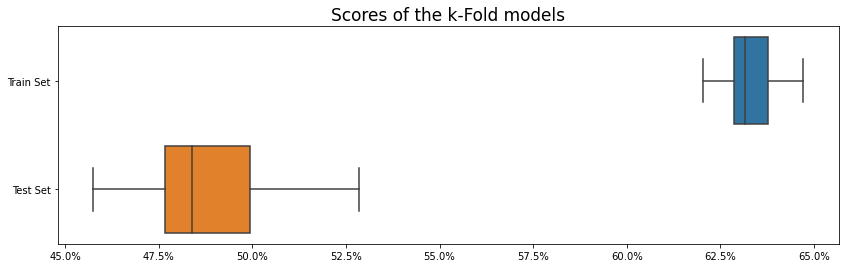

In [405]:
import matplotlib.ticker as mtick
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Mean Train score: {:2.1f}%".format(np.mean(scores_train) * 100))
print("Mean Test score: {:2.1f}%".format(np.mean(scores_test) * 100))

scores = pd.DataFrame.from_dict({
    "Train Set": scores_train,
    "Test Set": scores_test
})

plt.figure(figsize=(14, 4))
sns.boxplot(data=scores, orient="h")
plt.title("Scores of the k-Fold models", fontsize=17)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
plt.show()

### Check the scores

In [406]:
model = KNeighborsClassifier(**hyp_params)
model.fit(X_train, y_train)

KNeighborsClassifier()

In [407]:
print("Train score: {:2.1f}%".format(f1_score(y_train, model.predict(X_train)) * 100))
print("Test score: {:2.1f}%".format(f1_score(y_test, model.predict(X_test)) * 100))

Train score: 63.1%
Test score: 50.5%


In [408]:
from sklearn.metrics import recall_score, precision_score

print("Precision Test : {:2.1f}%".format(precision_score(y_test, model.predict(X_test)) * 100))
print("Recall Test : {:2.1f}%".format(recall_score(y_test, model.predict(X_test)) * 100))

Precision Test : 63.1%
Recall Test : 42.1%


In [409]:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test,  model.predict(X_test)).ravel()

print()
print('Confusion Matrix')
print('=================')
print('TN =', str(tn), end=' | ')
print('FP =', str(fp))
print('-----------------')
print('FN =', str(fn), end=' | ')
print('TP =', str(tp))


Confusion Matrix
TN = 1544 | FP = 90
-----------------
FN = 212 | TP = 154


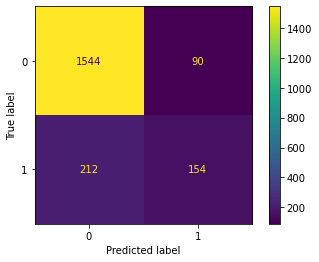

In [410]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, model.predict(X_test))

# AUC curve


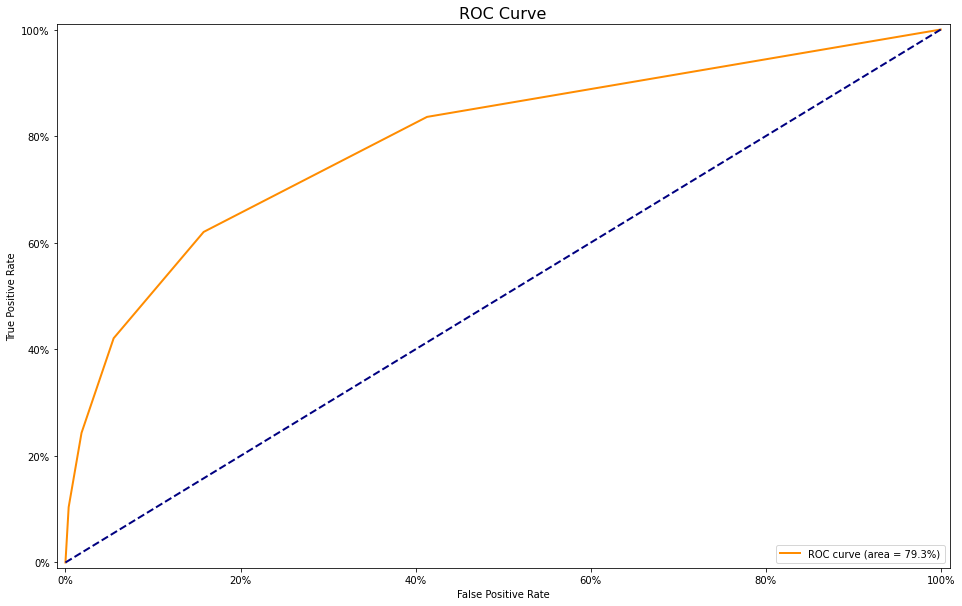

In [411]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(16, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:2.1f}%)'.format(auc(fpr, tpr) * 100))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.title("ROC Curve", fontsize=16)
plt.legend(loc="lower right")

In [412]:
# Print the AUC
print("The AUC: {}%".format(round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])*100, 2)))

The AUC: 79.31%
